<a href="https://colab.research.google.com/github/agrezende/dask-tutorial/blob/develop/00_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup inicial para utilização do Google Colab

Para a utilização dos notebooks no Google Colab, algumas configurações são necessárias.

Reproduzir os comandos desse notebook em todos aqueles que for necessário alguma preparação.

Para utilização em ambiente Jupyter Lab, outros ajustes são necessários.

In [ ]:
# !pip install dask==1.0.0 distributed'>=1.21.6,<2.0.0'
# !pip install dask==1.0.0 distributed==1.28.1

In [ ]:
# !pip freeze > antes.txt
# !pip install dask distributed --upgrade
# !pip freeze > depois.txt

In [ ]:
# !diff antes.txt depois.txt

In [ ]:
# Devido a varios erros encontrados, eh necessario realizar o upgrade de versao do pacotes:
# dask, distributed
# distributed==1.25.3
# cloudpickle (sera atualizado como dependencia)
# Em 16/03/2021:
# < cloudpickle==1.3.0
# > cloudpickle==1.6.0
# < dask==2.12.0
# > dask==2021.3.0
# < distributed==1.25.3
# > distributed==2021.3.0

!pip freeze > antes.txt
!pip install dask distributed --upgrade
!pip freeze > depois.txt
!echo Alteracoes:
# !diff antes.txt depois.txt && echo a || echo b
!diff --side-by-side --suppress-common-lines antes.txt depois.txt && echo Nao houve alteracoes
!rm antes.txt depois.txt

Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.3.0)
Requirement already up-to-date: distributed in /usr/local/lib/python3.7/dist-packages (2021.3.0)
Alteracoes:
Nao houve alteracoes


In [ ]:
from dask.distributed import Client

client = Client(n_workers=4)

# client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='2GB', scheduler_port=8780)

client

/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34639 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:41825 Dashboard: http://127.0.0.1:34639/status,Cluster Workers: 4 Cores: 4 Memory: 13.65 GB


## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [ ]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [ ]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 360 ms, sys: 66.5 ms, total: 426 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [ ]:
from dask import delayed

In [ ]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 2.37 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

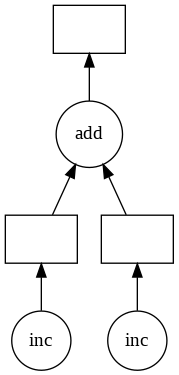

In [ ]:
z.visualize()

In [ ]:
# %%time
# This actually runs our computation using a local thread pool

z.compute()

5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [ ]:
z

Delayed('add-bfc8ed63-5df3-4ff6-9c98-8f18c1a83fc9')

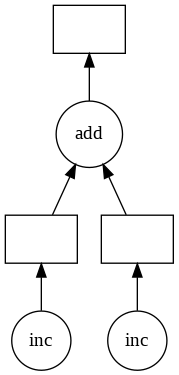

In [ ]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 807 ms, sys: 133 ms, total: 941 ms
Wall time: 8.01 s


In [ ]:
total

44

In [ ]:
%%time
# Your parallel code here...
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)


CPU times: user 631 µs, sys: 699 µs, total: 1.33 ms
Wall time: 2.62 ms


In [ ]:
%%time
total.compute()

CPU times: user 232 ms, sys: 32.5 ms, total: 264 ms
Wall time: 2.04 s


44

In [ ]:
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
# result = total.compute()
# print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-1e154440-13cb-45f9-994d-13e148118352')


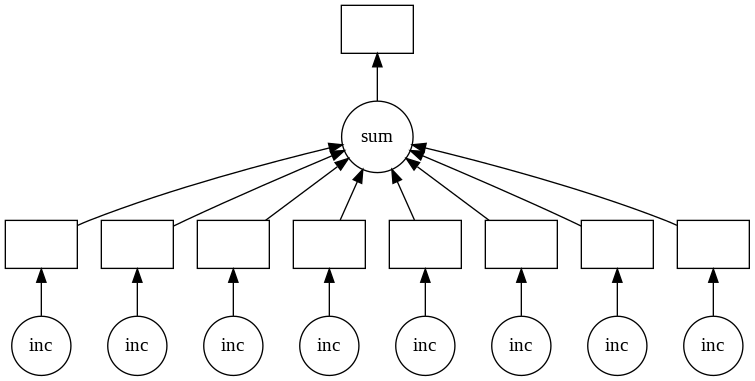

In [ ]:
total.visualize()

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
  result = total.compute()

In [ ]:
result = total.compute()
print("After computing :", result)  # After it's computed

After computing : 44


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [ ]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 936 ms, sys: 178 ms, total: 1.11 s
Wall time: 10 s


In [ ]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total)

Delayed('sum-71f2781b-4662-4fde-9965-a11c26a49100')
CPU times: user 3.29 ms, sys: 0 ns, total: 3.29 ms
Wall time: 4.81 ms


In [ ]:
%%time
total.compute()

CPU times: user 320 ms, sys: 56.4 ms, total: 376 ms
Wall time: 3.05 s


90

In [ ]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [ ]:
%time total.compute()

CPU times: user 313 ms, sys: 43.5 ms, total: 357 ms
Wall time: 3.04 s


90

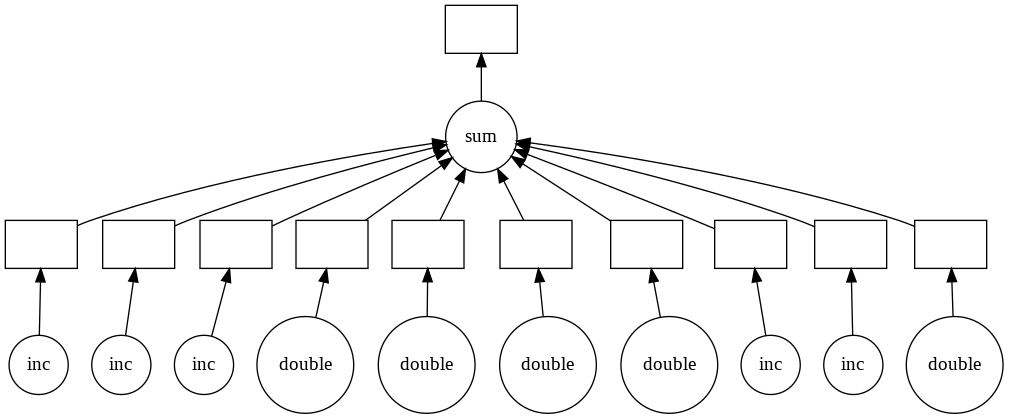

In [ ]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

## Create data

Run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [ ]:
!git clone https://github.com/agrezende/dask-tutorial.git

Cloning into 'dask-tutorial'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 2673 (delta 130), reused 162 (delta 106), pack-reused 2452
Receiving objects: 100% (2673/2673), 84.09 MiB | 24.24 MiB/s, done.
Resolving deltas: 100% (1720/1720), done.


In [ ]:
import os
!pwd
os.chdir('/content/dask-tutorial')
!pwd

/content
/content/dask-tutorial


In [ ]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 5.04s**


### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,81,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,81,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,81,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,81,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,81,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [ ]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
# filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

# Para funcionar corretamente com a leitura atradada, eh necessario o path completo:
filenames = sorted(glob(os.path.join('/content/dask-tutorial/data', 'nycflights', '*.csv')))

In [ ]:
# filenames

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    # print("Lendo {}".format(fn))
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 6.52 s, sys: 289 ms, total: 6.81 s
Wall time: 6.85 s


In [ ]:
# %time mean

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
from dask import compute

In [ ]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    # print("Lendo {}".format(fn))
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print(mean)

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 6.59 s, sys: 220 ms, total: 6.81 s
Wall time: 6.95 s


In [ ]:
# mean

In [ ]:
# %%time
# # your code here

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    # fn = "/content/dask-tutorial/" + fn
    # print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
# total_delays = sum(sums)
# n_flights = sum(counts)
# mean = total_delays / n_flights

CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 16.6 ms


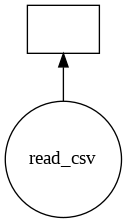

In [ ]:
display(df.visualize())

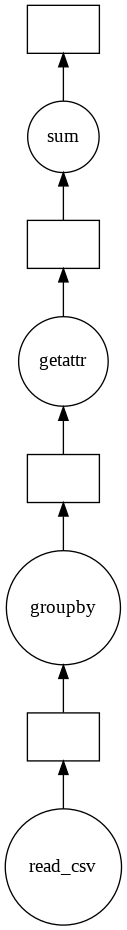

In [ ]:
display(total.visualize())

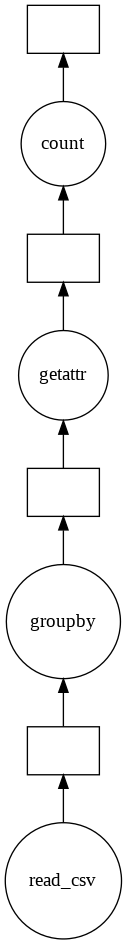

In [ ]:
count.visualize()

In [ ]:
%%time
# Compute the intermediates
sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 1.01 s, sys: 137 ms, total: 1.15 s
Wall time: 8.08 s


In [ ]:
%%time
# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 7.61 ms, sys: 8 µs, total: 7.62 ms
Wall time: 10.2 ms


In [ ]:
%%time
# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
# mean = total_delays / n_flights

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.63 ms


In [ ]:
mean = total_delays / n_flights

In [ ]:
mean

Delayed('truediv-a064f8fc90599ca50e373fbb30587302')

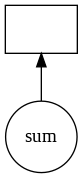

In [ ]:
display(total_delays.visualize())

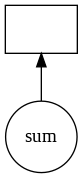

In [ ]:
display(n_flights.visualize())

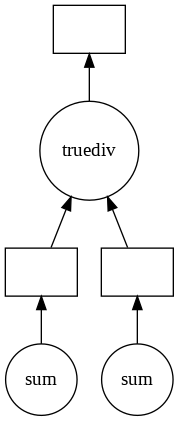

In [ ]:
mean.visualize()

In [ ]:
%time mean = mean.compute()

CPU times: user 23.1 ms, sys: 3.84 ms, total: 26.9 ms
Wall time: 59.3 ms


In [ ]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    # fn = "/content/dask-tutorial/" + fn
    # print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
print(mean.compute())

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 1.02 s, sys: 127 ms, total: 1.15 s
Wall time: 6.82 s


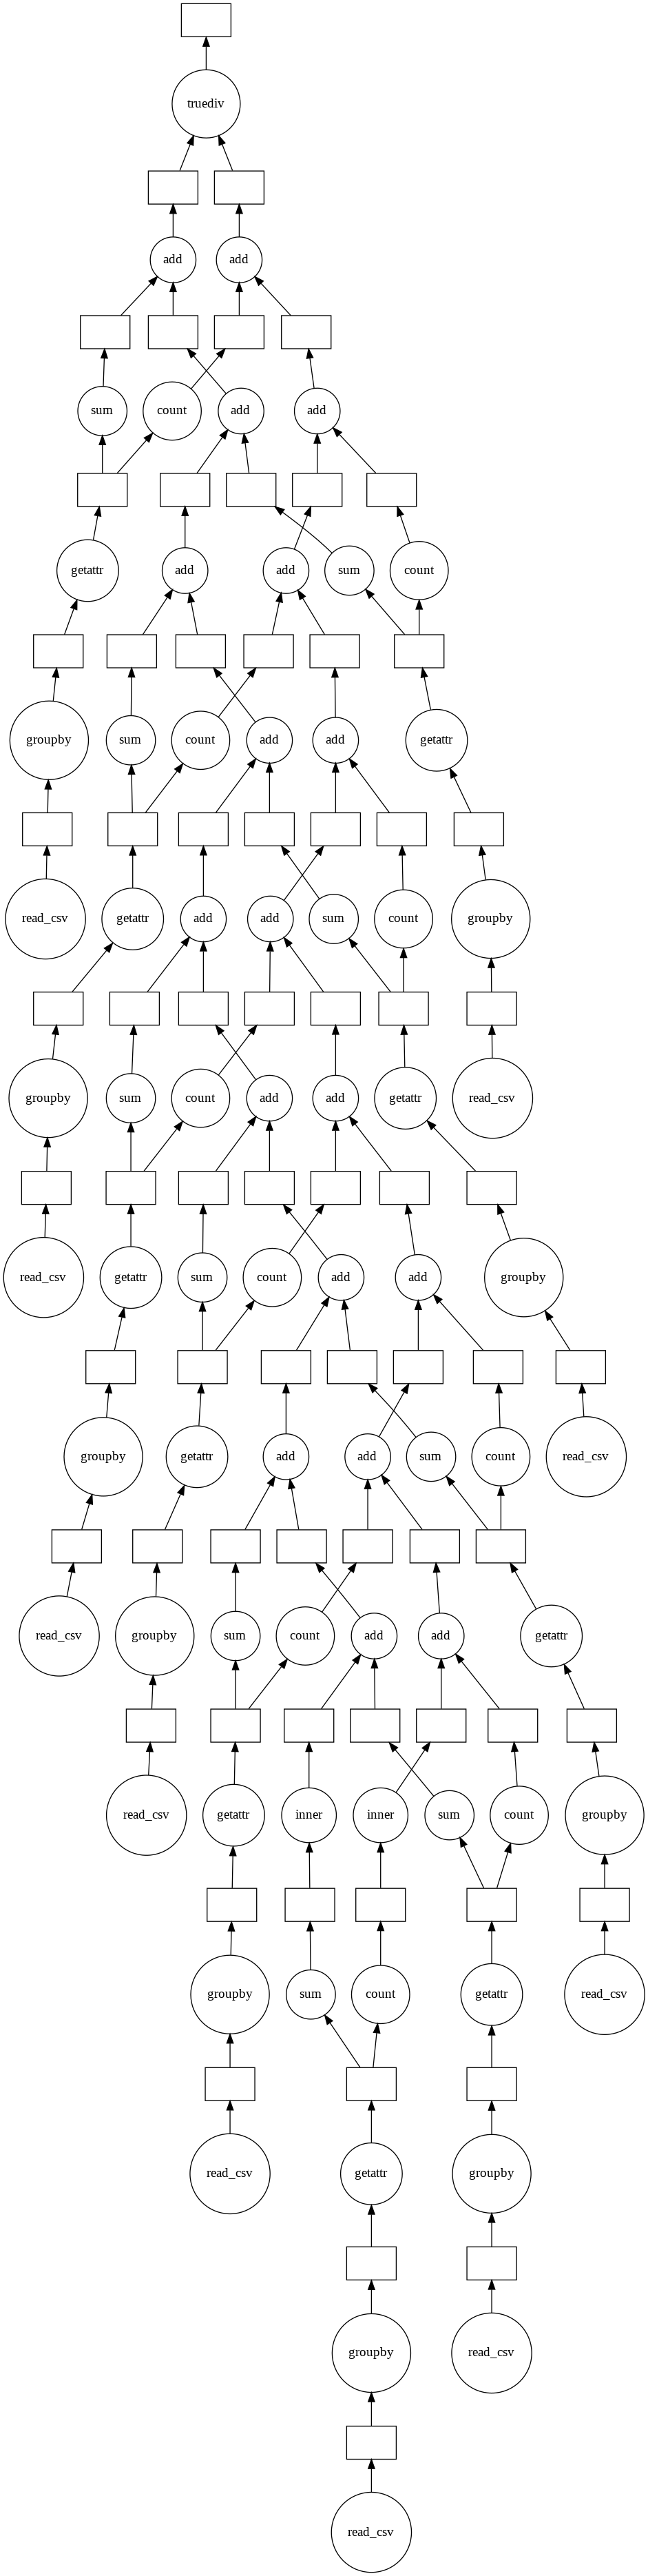

In [ ]:
mean.visualize()

In [ ]:
%%time
mean.compute()

CPU times: user 795 ms, sys: 93.3 ms, total: 889 ms
Wall time: 6.27 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

# !pwd

sums = []
counts = []
for fn in filenames:
    # Read in file
    # fn = "/content/dask-tutorial/" + fn
    # print("Lendo {}".format(fn))
    # print(type(fn))
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
# sums, counts = compute(sums, counts)
# sums = compute(sums)
# counts = compute(counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
mean = total_delays / n_flights
print(mean.compute())

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64
CPU times: user 727 ms, sys: 100 ms, total: 828 ms
Wall time: 6.06 s


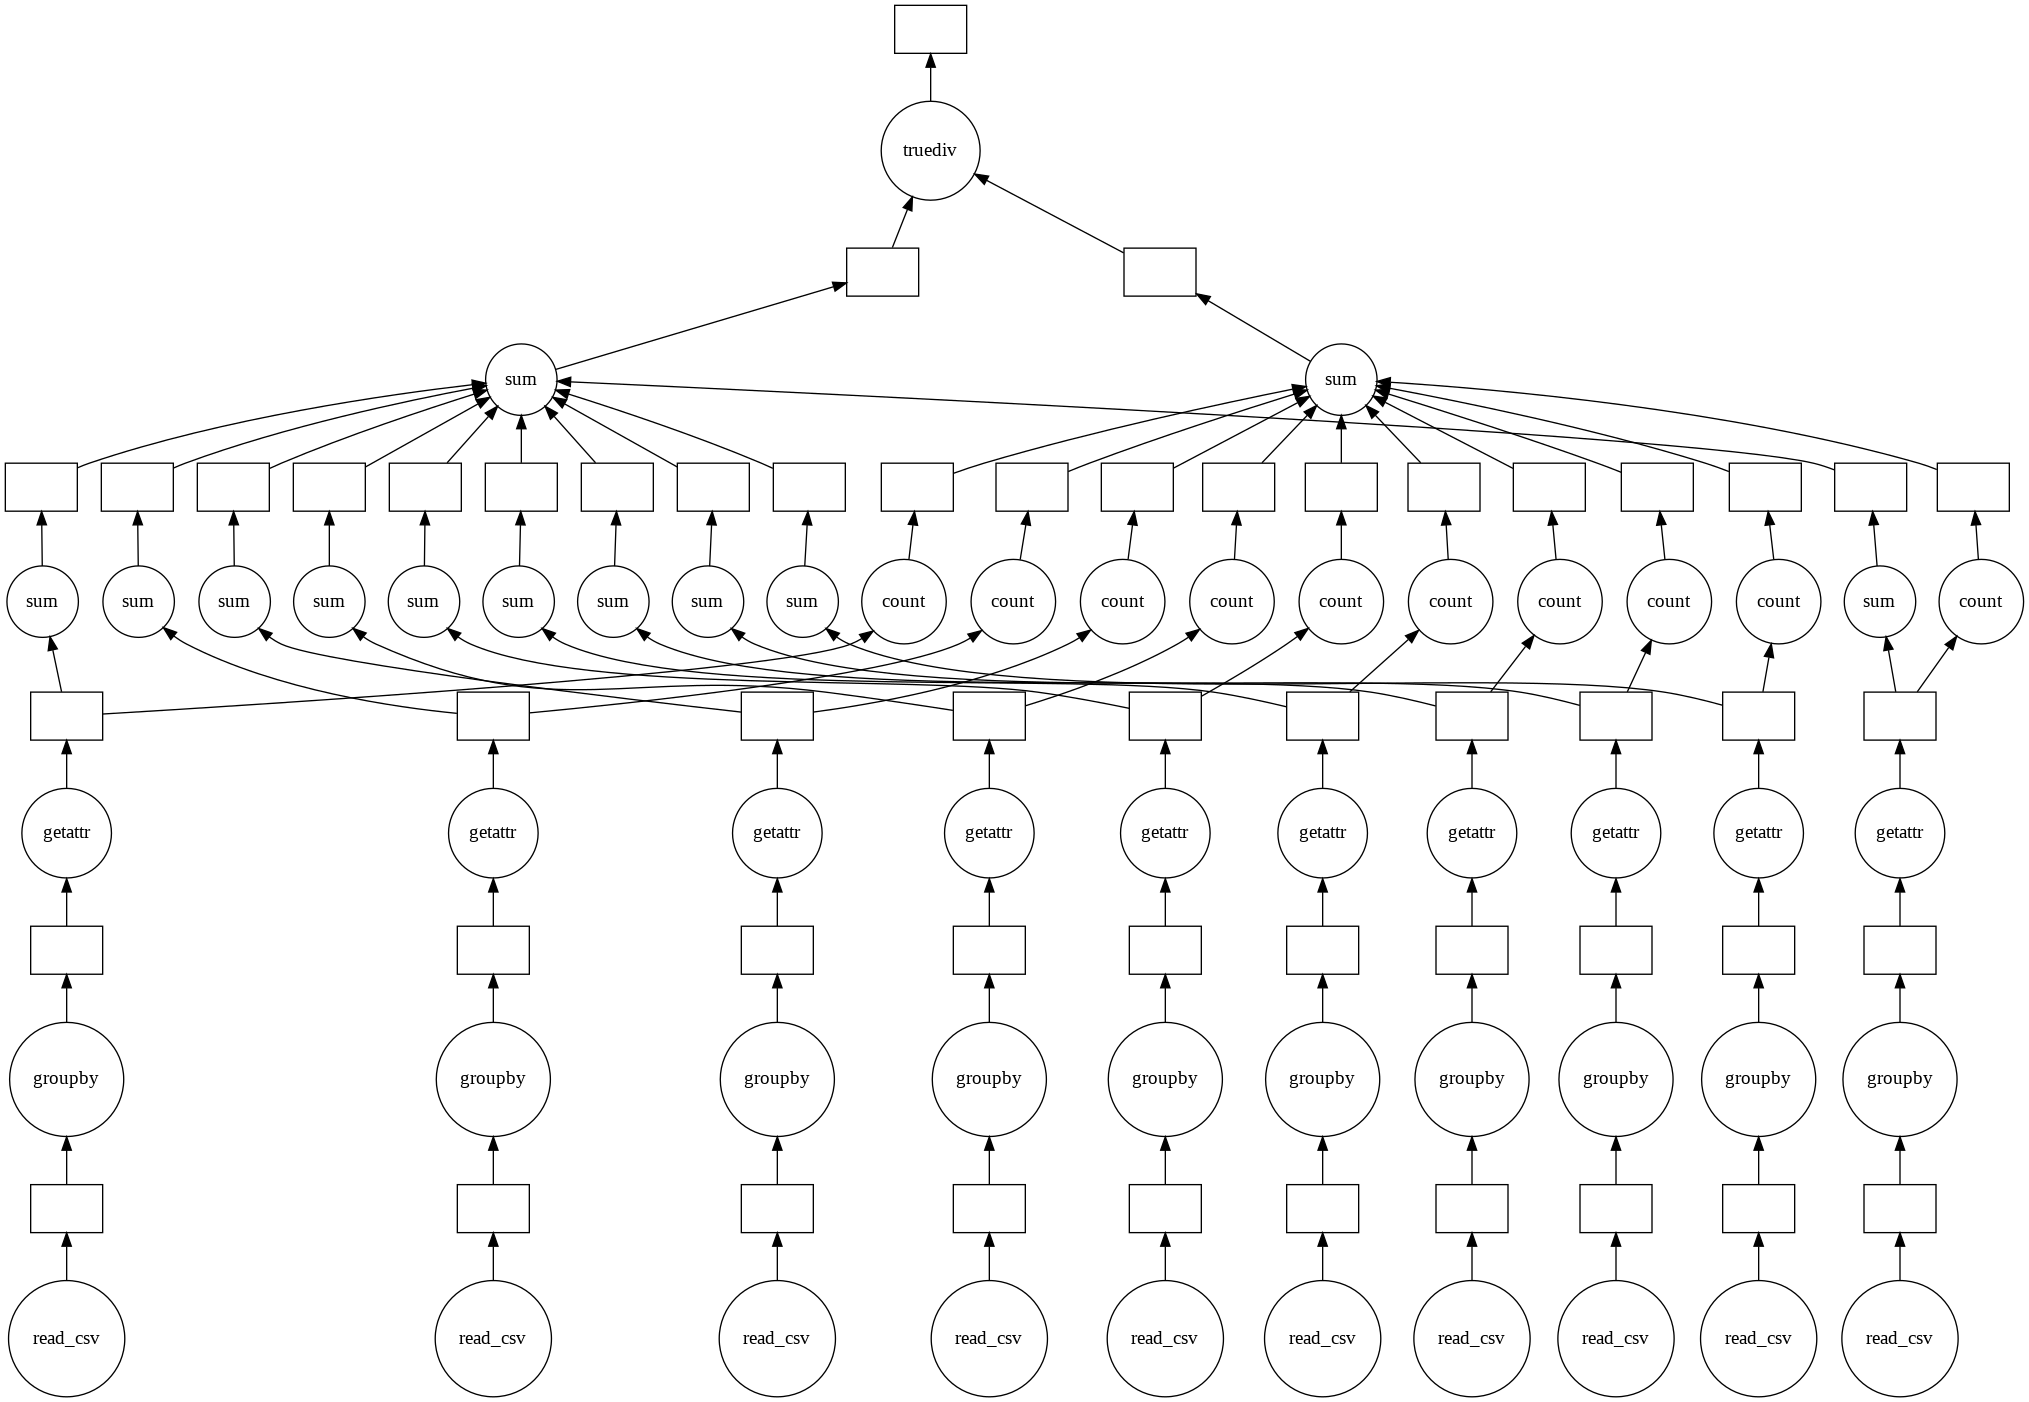

In [ ]:
mean.visualize()

In [ ]:
%%time
mean.compute()

CPU times: user 683 ms, sys: 93.7 ms, total: 777 ms
Wall time: 5.75 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [ ]:
client.close()

In [ ]:
client

Client Scheduler: tcp://127.0.0.1:41825 Dashboard: http://127.0.0.1:34639/status,Cluster Workers: 0 Cores: 0 Memory: 0 B
